In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from dataprep import transform_indices
from polara.preprocessing.dataframes import reindex, leave_one_out

import pickle

2023-03-28 12:32:11.039314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 12:32:11.186977: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28 12:32:11.776898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 12:32:11.776980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
data = pd.read_csv('training.csv')

In [3]:
data['movieid'].max()

48118.0

In [65]:
data['userid'].max()

283222

In [5]:
# source code from seminar
test_timepoint = data['timestamp'].quantile(q=0.80, interpolation='nearest')

test_data_ = data.query('timestamp >= @test_timepoint')
train_data_ = data.query('userid not in @test_data_.userid.unique() and timestamp < @test_timepoint')

train_data, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')
test_data = reindex(test_data_, data_index['items'])

Filtered 107673 invalid observations.


In [28]:
y = data['rating'].astype('float32')

In [18]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

In [19]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [23]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [26]:
raw_train = train_data.reset_index(drop=True)
raw_val  = testset_valid.reset_index(drop=True)
raw_test  = holdout_valid.reset_index(drop=True)

In [29]:
# Feed into tf dataset
# shuffle and batch
train_ds = tf.data.Dataset.from_tensor_slices((dict(raw_train), y.iloc[raw_train.index])).shuffle(len(raw_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((dict(raw_val), y.iloc[raw_val.index])).shuffle(len(raw_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((dict(raw_test), y.iloc[raw_test.index])).shuffle(len(raw_test)).batch(32)

2023-03-28 12:34:04.897812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 12:34:04.897855: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 12:34:04.897890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-03-28 12:34:04.898204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define inputs and feature columns

In [30]:
# Define tensorflow inputs
inputs = {          
          'movieid' : tf.keras.layers.Input(name='movieid', shape=(), dtype = 'int32'),
          'userid': tf.keras.layers.Input(name='userid', shape=(), dtype='int32'),
}

In [32]:
# <--movieId-->
# Categorized
movie_col = tf.feature_column.categorical_column_with_identity(key='movieid', num_buckets=48119)         
# Embedding
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
# Indicator
movie_ind_col = tf.feature_column.indicator_column(movie_col)

# <--userId-->
# Categorized
user_col = tf.feature_column.categorical_column_with_identity(key='userid', num_buckets=283223)
# Embedding
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
# Indicator
user_ind_col = tf.feature_column.indicator_column(user_col)

categorical_columns = [movie_emb_col, user_emb_col]

#### Utility functions

Reference:

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [59]:
# Define function to plot training and validation loss 

def plot(history):
    
    cross_entropy_train = history.history['loss']
    cross_entropy_val = history.history['val_loss']

    plt.title('Training and validation binary cross entropy loss')
    plt.plot(cross_entropy_train, color='blue', label='Train')
    plt.plot(cross_entropy_val, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend()

In [35]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=8,
    mode='auto',
    restore_best_weights=True)

#### NeuralCF

References: 

https://androidkt.com/concatenate-two-layers-using-keras-layers-concatenate-example/

https://towardsdatascience.com/a-performant-recommender-system-without-cold-start-problem-69bf2f0f0b9b

https://keras.io/api/models/model_training_apis/

In [36]:
# NeuralCF

# Concatenate userid embedding and movieid embedding 
mlp = tf.keras.layers.concatenate([tf.keras.layers.DenseFeatures([movie_emb_col])(inputs), tf.keras.layers.DenseFeatures([user_emb_col])(inputs)])

mlp = tf.keras.layers.Dense(64, activation='relu')(mlp)
mlp = tf.keras.layers.Dense(32, activation='relu')(mlp)

# Output Layer
neuralCF_output_layer = tf.keras.layers.Dense(1)(mlp)

# Define model
neuralCF_model = tf.keras.Model(inputs, neuralCF_output_layer)

In [45]:
neuralCF_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    optimizer='adam'
)

In [46]:
neuralCF_history = neuralCF_model.fit(train_ds,
                validation_data = val_ds, 
                callbacks=[early_stopping],
                epochs=10)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['rating', 'timestamp'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2023-03-28 13:10:42.112759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3780819 of 4427415


     8/138357 [..............................] - ETA: 59:05 - loss: -1703492714496.0000  

2023-03-28 13:10:43.833883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1550s 11ms/step - loss: -10974350278656.0000 - val_loss: -22637887619072.0000
Epoch 2/10


2023-03-28 13:36:36.728566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 822554 of 4427415
2023-03-28 13:36:42.069554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1690153 of 4427415
2023-03-28 13:36:52.082435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3019791 of 4427415


     6/138357 [..............................] - ETA: 53:13 - loss: -26727522762752.0000   

2023-03-28 13:37:01.365450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1960s 14ms/step - loss: -73543035387904.0000 - val_loss: -112791629332480.0000
Epoch 3/10


2023-03-28 14:09:23.807403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 756762 of 4427415
2023-03-28 14:09:23.807710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 756763 of 4427415
2023-03-28 14:09:32.621996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2484589 of 4427415
2023-03-28 14:09:42.632043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3604283 of 4427415


     5/138357 [..............................] - ETA: 1:14:21 - loss: -138763304960000.0000  

2023-03-28 14:09:52.621994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4420661 of 4427415
2023-03-28 14:09:52.646900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 2030s 14ms/step - loss: -269109077999616.0000 - val_loss: -352649295691776.0000
Epoch 4/10


2023-03-28 14:43:04.167002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3456421 of 4427415
2023-03-28 14:43:12.524435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4338025 of 4427415


     4/138357 [..............................] - ETA: 1:28:20 - loss: -430093092519936.0000 

2023-03-28 14:43:13.417547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1976s 14ms/step - loss: -717874926714880.0000 - val_loss: -854247386120192.0000
Epoch 5/10


2023-03-28 15:15:59.676600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3467922 of 4427415
2023-03-28 15:16:08.368764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4365943 of 4427415


     5/138357 [..............................] - ETA: 1:14:57 - loss: -990745137774592.0000 

2023-03-28 15:16:08.616690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1943s 14ms/step - loss: -1579031438819328.0000 - val_loss: -1761105168826368.0000
Epoch 6/10


2023-03-28 15:48:26.525338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1040278 of 4427415
2023-03-28 15:48:31.890976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1677227 of 4427415
2023-03-28 15:48:45.007400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3897695 of 4427415
2023-03-28 15:48:52.737938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4322109 of 4427415


     6/138357 [..............................] - ETA: 49:49 - loss: -2296417813004288.0000   

2023-03-28 15:48:54.181871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1998s 14ms/step - loss: -3051697744117760.0000 - val_loss: -3247861785427968.0000
Epoch 7/10


2023-03-28 16:21:46.503657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 870581 of 4427415
2023-03-28 16:21:49.992433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1228691 of 4427415
2023-03-28 16:22:04.787686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3790604 of 4427415
2023-03-28 16:22:09.992356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3897685 of 4427415


     5/138357 [..............................] - ETA: 1:11:28 - loss: -3828621357613056.0000 

2023-03-28 16:22:15.987834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1989s 14ms/step - loss: -5365970541477888.0000 - val_loss: -5504015085338624.0000
Epoch 8/10


2023-03-28 16:54:58.398626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1249280 of 4427415
2023-03-28 16:54:59.425301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1280964 of 4427415
2023-03-28 16:55:09.425290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3549892 of 4427415
2023-03-28 16:55:19.425291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3949082 of 4427415
2023-03-28 16:55:23.762376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1990s 14ms/step - loss: -8773863882096640.0000 - val_loss: -8757967671263232.0000
Epoch 9/10


2023-03-28 17:28:14.751854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 905137 of 4427415
2023-03-28 17:28:14.773511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 905138 of 4427415
2023-03-28 17:28:19.772373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1283590 of 4427415
2023-03-28 17:28:35.383355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3777877 of 4427415
2023-03-28 17:28:39.775381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3778055 of 4427415


     6/138357 [..............................] - ETA: 1:15:38 - loss: -10035143842463744.0000

2023-03-28 17:28:49.291549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 1989s 14ms/step - loss: -13592467685244928.0000 - val_loss: -13275815852638208.0000
Epoch 10/10


2023-03-28 18:01:19.504582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 810456 of 4427415
2023-03-28 18:01:19.524035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 810457 of 4427415
2023-03-28 18:01:28.838882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2789101 of 4427415
2023-03-28 18:01:38.852902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3760327 of 4427415


     6/138357 [..............................] - ETA: 55:16 - loss: -18006101706407936.0000    

2023-03-28 18:01:47.737776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 2027s 14ms/step - loss: -20165839969845248.0000 - val_loss: -19349061744197632.0000


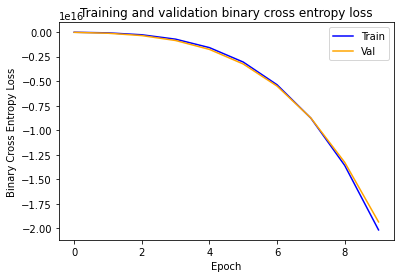

In [60]:
plot(neuralCF_history)

In [64]:
# Save models to disk
neuralCF_model.save('neuralCF_2_crossE', include_optimizer=False, )

INFO:tensorflow:Assets written to: neuralCF_2_crossE/assets
